In [ ]:
# switch to TF environment
from tensorflow.keras.models import  Model
from tensorflow.keras.layers import Dense, LSTM, Masking, TimeDistributed, Input
from tensorflow.keras import backend as K
import numpy as np
import os
from scipy.signal import find_peaks
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.style as style
style.use('tableau-colorblind10')

## Function definitions

In [2]:
dimension = 2 # spatial dimension 
minSeg = 3 # minimum segment length allowed
padval = -99. # padding value that is masked by the nets

In [3]:
# run to define the loss functions for the models below
def masked_mse(y_true, y_pred, padval=-99.):
    a_output = y_pred[:, :, 0]
    K_output = y_pred[:, :, 1]
    true_a = y_true[:, :, 0]
    true_K = y_true[:, :, 1]

    # MSE for alpha
    mask = K.cast(K.not_equal(true_a, padval), dtype=a_output.dtype)
    squared_diff = K.square(true_a - a_output)
    masked_squared_diff = squared_diff * mask

    #MSLE for K
    true_K=true_K*mask
    K_output=K_output*mask
    log_diff = K.square(K.log(true_K+1) - K.log(K_output+1))
    masked_log_diff = log_diff * mask

    # Summing and averaging over the non-padded timesteps
    num_non_padding = K.sum(mask)
    mse = K.sum(masked_squared_diff) / (num_non_padding + K.epsilon())  + 2*K.sum(masked_log_diff) / (num_non_padding + K.epsilon())
    return mse

def masked_mae(y_true, y_pred): # masked mean absolute error
    padval=-99.
    float_output = y_pred
    true_float = y_true

    mask = K.cast(K.not_equal(true_float, padval), dtype=float_output.dtype)
    squared_diff = K.cast(K.abs(true_float - float_output), dtype=float_output.dtype)
    masked_squared_diff = squared_diff * mask
    # Summing and averaging over the non-padded timesteps
    num_non_padding = K.sum(mask)
    mse = K.sum(masked_squared_diff) / (num_non_padding + K.epsilon())  # Adding epsilon to avoid division by zero
    return mse

def OrdEnt(y_true, y_pred): # an *ordinal* sparse categorical crossentropy
    maxInt = 3.
    padval=int(-99.)
    numCP_true = tf.cast(y_true, dtype=tf.int32)
    numCP_pred = y_pred

    mask = tf.cast(tf.not_equal(numCP_true, padval), dtype=numCP_true.dtype)
    numCP_true=numCP_true*mask # cant have -99 in the label for cross ent

    numCP_loss = K.sparse_categorical_crossentropy(numCP_true, numCP_pred)
    mask=tf.cast(mask, dtype=numCP_loss.dtype)
    numCP_loss = numCP_loss * mask
    weights = K.abs(K.cast(numCP_true, dtype=tf.float32) - K.cast(K.argmax(numCP_pred, axis=-1),dtype=tf.float32))/maxInt

    return tf.reduce_sum((1.0+weights*mask)*numCP_loss) / tf.cast(tf.reduce_sum(mask), dtype=numCP_loss.dtype)

def maskedBin(y_true, y_pred): # masked binary entropy
    padval=int(-99.)
    numCP_true = tf.cast(y_true, dtype=tf.int32)
    numCP_pred = y_pred

    mask = tf.cast(tf.not_equal(numCP_true, padval), dtype=numCP_true.dtype)
    numCP_true=numCP_true*mask # cant have -99 in the label for cross ent

    numCP_loss = K.binary_crossentropy(tf.cast(numCP_true, dtype=numCP_pred.dtype), numCP_pred)
    numCP_loss = numCP_loss*tf.cast(mask, dtype=numCP_loss.dtype)

    return tf.reduce_sum(numCP_loss) / tf.cast(tf.reduce_sum(mask), dtype=numCP_loss.dtype)

def int_acc(y_true, y_pred): # masked accuracy from sparse (integer) labels
    padval=int(-99.)
    numCP_true = tf.cast(y_true, tf.int64)
    numCP_pred = y_pred

    mask = tf.not_equal(numCP_true, padval)
    correct_predictions = tf.equal(numCP_true, tf.argmax(numCP_pred, axis=-1))
    acc = tf.reduce_sum(tf.cast(correct_predictions, tf.float32) * tf.cast(mask, tf.float32)) / tf.reduce_sum(tf.cast(mask, tf.float32))
    return acc

In [4]:
def buildArchitectureCPtOnly(minSeg, padval, dimension): # defines network for model to predict where changepoints occur
    block_size = minSeg*(dimension+1)                                   # Size of the blocks of data points

    input_shape = (None, block_size)  
    inputs = Input(shape=input_shape)
    masked_inputs = Masking(mask_value=padval)(inputs) # masking layer with specific padding value

    lstm_out = LSTM(250,                              # first layer: LSTM of dimension 250
                    return_sequences=True,            # return sequences for the second LSTM layer            
                    recurrent_dropout=0.2,            # recurrent dropout for preventing overtraining
                    input_shape=(None, block_size))(masked_inputs)
    # but LSTM input is 3D, this is added on as batch size later? should batches have same length trajectories or just blocks constant
                                                            
    lstm2_out = LSTM(50,                              # second layer: LSTM of dimension 50
                    return_sequences=True,            # also returns sequences, into the TimeDistributed
                    recurrent_dropout=0.2,           
                    dropout=0)(lstm_out)
    
    yn_output_layer = TimeDistributed(Dense(1, activation='sigmoid'), name='yn_output')(lstm2_out) # 1 binary prediction per sequence point
    OH_output_layer = TimeDistributed(Dense(4, activation='softmax'), name='OH_output')(lstm2_out) # ordinal classification for exact changepoint location in block
    model_inference = Model(inputs=inputs, outputs=[yn_output_layer,OH_output_layer])
    model_inference.compile(optimizer='adam', 
                            loss={
                                  'yn_output':maskedBin,
                                  'OH_output':OrdEnt}, 
                            metrics={
                                     'yn_output':'accuracy',
                                     'OH_output':int_acc}, 
                            loss_weights={
                                  'yn_output':1.,
                                  'OH_output':1.})
    
    print(model_inference.summary())

    return model_inference

model_CPtOnly = buildArchitectureCPtOnly(minSeg, padval, dimension)

model_CPtOnly.load_weights('DynamicCP_Weights.h5')



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, 9)]            0         []                            
                                                                                                  
 masking (Masking)           (None, None, 9)              0         ['input_1[0][0]']             
                                                                                                  
 lstm (LSTM)                 (None, None, 250)            260000    ['masking[0][0]']             
                                                                                                  
 lstm_1 (LSTM)               (None, None, 50)             60200     ['lstm[0][0]']                
                                                                                            

In [5]:
def buildArchitectureCPtKandA(minSeg, padval, dimension): # defines the network for the model predicting changepoints, K and alpha
    
    block_size = minSeg*(dimension+1)                               

    input_shape = (None, block_size)  
    inputs = Input(shape=input_shape)
    masked_inputs = Masking(mask_value=padval)(inputs)

    lstm_out = LSTM(250,                            
                    return_sequences=True,                      
                    recurrent_dropout=0.2,            
                    input_shape=(None, block_size))(masked_inputs)
                                                            
    lstm2_out = LSTM(50,                              
                    return_sequences=True,          
                    recurrent_dropout=0.2,           
                    dropout=0)(lstm_out)
    
    fl_output_layer = TimeDistributed(Dense(2), name='fl_output')(lstm2_out) # 2 floats: alpha and K, for regression on every point in sequence
    yn_output_layer = TimeDistributed(Dense(1, activation='sigmoid'), name='yn_output')(lstm2_out)
    OH_output_layer = TimeDistributed(Dense(4, activation='softmax'), name='OH_output')(lstm2_out)
    model_inference = Model(inputs=inputs, outputs=[fl_output_layer,yn_output_layer,OH_output_layer])
    model_inference.compile(optimizer='adam', 
                            loss={'fl_output':masked_mse,
                                  'yn_output':maskedBin,
                                  'OH_output':OrdEnt}, 
                            metrics={'fl_output':masked_mae,
                                     'fl_output':masked_mse,
                                     'yn_output':'accuracy',
                                     'OH_output':int_acc}, 
                            loss_weights={'fl_output':1.,
                                  'yn_output':1.,
                                  'OH_output':1.})
    
    print(model_inference.summary())

    return model_inference

model_CPtKanda = buildArchitectureCPtKandA(minSeg, padval, dimension)

model_CPtKanda.load_weights('DynamicCP_KandA_Weights.h5')

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, 9)]            0         []                            
                                                                                                  
 masking_1 (Masking)         (None, None, 9)              0         ['input_2[0][0]']             
                                                                                                  
 lstm_2 (LSTM)               (None, None, 250)            260000    ['masking_1[0][0]']           
                                                                                                  
 lstm_3 (LSTM)               (None, None, 50)             60200     ['lstm_2[0][0]']              
                                                                                            

In [6]:
# Data Preparation; retrieves *increments* from the positions, normalises them, and pads the trajectories to accomodate the blocks.
def data_prepare(X,N,dimension,blocksize,padval,maxLen):                 
    thr=1e-10
    r = [np.diff(xi,axis=1) for xi in X] # taking the increments along each dimension of each trajectory
    sxy = [np.std(ri.flatten()) for ri in r] # the std of both x and y increments of each trajectory
    meanxy = [np.mean(ri.flatten()) for ri in r] # the mean of both x and y increments of each trajectory

    # maxLen=(maxLen-1)//minSeg + 1
    maxLen = (maxLen-1)//minSeg + (1 if (maxLen-1)%minSeg != 0 else 0)
    datLen = int(blocksize/minSeg) # size of the vector for each position.
    
    x = []
    for i, ri in enumerate(r): # each iteration a different traj
        trajlen=len(ri[0])
        y=ri
        mu=np.full((dimension,1),meanxy[i])
        sig=np.full((dimension,1),sxy[i])
        y = (y-mu) / np.where(sxy[i]>thr,sig,1)   # len(y) == dimension
        y = np.array([[y[0][n], y[1][n],sxy[i]] for n in range(trajlen)]) # stack on the std of xy
        y=np.transpose(y,axes=[1,0])
        if (trajlen%minSeg) != 0:
            y = np.concatenate((y,np.full((datLen,minSeg-(trajlen%minSeg)),padval)),axis=1) 

        padding = maxLen-int(datLen*len(y[0])/blocksize) # This padding does not affect the predictions, but having all trajectories be the same length helps to process together in arrays.
        if  padding > 0:
            y = np.concatenate((y,np.full((datLen,padding*minSeg),padval)),axis=1)

        y=np.transpose(y,axes=[1,0])
        y=y.reshape(int(datLen*(len(y))/blocksize),blocksize)
        x.append(np.array(y))
    
    return x

## Data Preparation and Network Prediction

In [7]:
# Place two-dimensional trajectories in the list below, each should have shape (2, T) with T the total time index
rawTrajs = [np.load("paperTraj.npy")] # here we have just one trajectory, from the example in our paper

In [8]:
# Optional: corresponding trajectory labels
gtLabels = [np.load("paperTrajLabel.npy")]

In [9]:
maxLen = np.max([len(x[0]) for x in rawTrajs])
print(f"Maximum trajectort length in input: {maxLen}")

Maximum trajectort length in input: 200


In [10]:
block_size = minSeg*(dimension+1)
xin = data_prepare(rawTrajs,len(rawTrajs),dimension,block_size,padval, maxLen) # Prepare the data for the nets
xin2 = data_prepare([x[:,1:] for x in rawTrajs],len(rawTrajs),dimension,block_size,padval, maxLen) # Prepare it again, shifting (with a cut) by 1 point
xin3 = data_prepare([x[:,2:] for x in rawTrajs],len(rawTrajs),dimension,block_size,padval, maxLen) # shift by 2 points 

In [11]:
# use the nets to make predictions
predCPtKanda = model_CPtKanda.predict(np.array(xin))
predCPtKanda2 = model_CPtKanda.predict(np.array(xin2))
predCPtKanda3 = model_CPtKanda.predict(np.array(xin3))

cptPred = model_CPtOnly.predict(np.array(xin))
cptPred2 = model_CPtOnly.predict(np.array(xin2))
cptPred3 = model_CPtOnly.predict(np.array(xin3))

1/1 [==============================] - 0s 129ms/step


In [12]:
def roundThresh(arr, thr=0.5): # you may change the threhsold for rounding the binary CP prediction if you wish
    newarr=[]
    for d in arr:
        if d >= thr:
            d = -(d // -1)
        newarr.append(d // 1)
    return np.array(newarr).astype(int)

In [13]:
# sliding window, loops over all input trajectories

alphaMeansPred = [] # storage for point-wise predictions of anomalous diffusion exponent
KMeansPred = [] # storage for point-wise predictions of generalised diffusion coefficient
CPWinPred = [] # changepoint storage

cpsTrajSignal, cpsOrdCount = [], 0
trackt=0 # index of trajectory in the rawTrajs array to make CP(t) plot below
for t, traj in enumerate(rawTrajs):
    incLen = len(traj[0])-1 # number of increments 
    coarseLen=incLen//minSeg + (1 if incLen%minSeg != 0 else 0) # length of "coarse-grained" increment sequence input to the nets

    # extract the length of useful (unpadded) sequence in the in/output of the nets, for original (Xin) and shifted (Xin2, Xin3) trajectories
    check = len([p for p in xin[t][:,0] if p != padval]) 
    check2 = len([p for p in xin2[t][:,0] if p != padval]) 
    check3 = len([p for p in xin3[t][:,0] if p != padval])
    if check != coarseLen:
        print('AH')

    alphaWindowsPred = [[] for _ in range(incLen)] # tracking the value of alpha over the fully discretised time
    KWindowsPred = [[] for _ in range(incLen)] # tracking the value of K over the fully discretised time
    cpsTrajPred = np.zeros(incLen) # for tracking changepoint detections over the discretised time

    predBinwin = roundThresh(cptPred[0][t][:,0])[:coarseLen] # extract binary CP detections from unshifted
    predBinwin2 = roundThresh(cptPred2[0][t][:,0])[:check2] # extract binary CP detections from trajectory shifted by 1
    predBinwin3 = roundThresh(cptPred3[0][t][:,0])[:check3] # extract binary CP detections from trajectory shifted by 2
    predIntwin = np.argmax(cptPred[1][t], axis=-1)[:coarseLen] # extract precise block-CP detections
    predIntwin2 = np.argmax(cptPred2[1][t], axis=-1)[:check2] 
    predIntwin3 = np.argmax(cptPred3[1][t], axis=-1)[:check3]

    for i in range(incLen):
        alphaWindowsPred[i].append(predCPtKanda[0][t][:, 0][i//minSeg]) # taking coarse grained alpha predictions to the complete-time array
        KWindowsPred[i].append(predCPtKanda[0][t][:, 1][i//minSeg]) # K generalised diffusion coefficient predictions
        cpsTrajPred[i] += predBinwin[i//minSeg] # record the binary classification predictions
    for i in range(incLen-1): # for the shifted trajectory
        alphaWindowsPred[i+1].append(predCPtKanda2[0][t][:, 0][i//minSeg])
        KWindowsPred[i+1].append(predCPtKanda2[0][t][:, 1][i//minSeg])
        cpsTrajPred[i+1] += predBinwin2[i//minSeg]
    for i in range(incLen-2): # for the twice shifted trajectory
        alphaWindowsPred[i+2].append(predCPtKanda3[0][t][:, 0][i//minSeg])
        KWindowsPred[i+2].append(predCPtKanda3[0][t][:, 1][i//minSeg])
        cpsTrajPred[i+2] += predBinwin3[i//minSeg] 
    for idx, cp in enumerate(predIntwin): # recording the ordinal classification predictions 
        if cp != 0:
            cpsTrajPred[idx*minSeg + cp - 1] += 1 # add one back in (shift right) for real CP, not the increment version this is (-1)
            cpsOrdCount +=1
    for idx, cp in enumerate(predIntwin2):
        if cp != 0:
            cpsTrajPred[1+idx*minSeg + cp - 1] += 1
            cpsOrdCount +=1
    for idx, cp in enumerate(predIntwin3):
        if cp != 0:
            cpsTrajPred[2+idx*minSeg + cp - 1] += 1
            cpsOrdCount +=1
    if t==trackt:
        cpsTrajSignal = cpsTrajPred.copy()
    alphaMeansPred.append([np.mean(a) for a in alphaWindowsPred])
    KMeansPred.append([np.mean(a) for a in KWindowsPred])
    CPWinPred.append(find_peaks(cpsTrajPred,height=2,distance=minSeg)[0] + 1) # noting the prominent detections from cpsTrajPred "histogram", note +1 put back
   

## Results on Example Trajectory

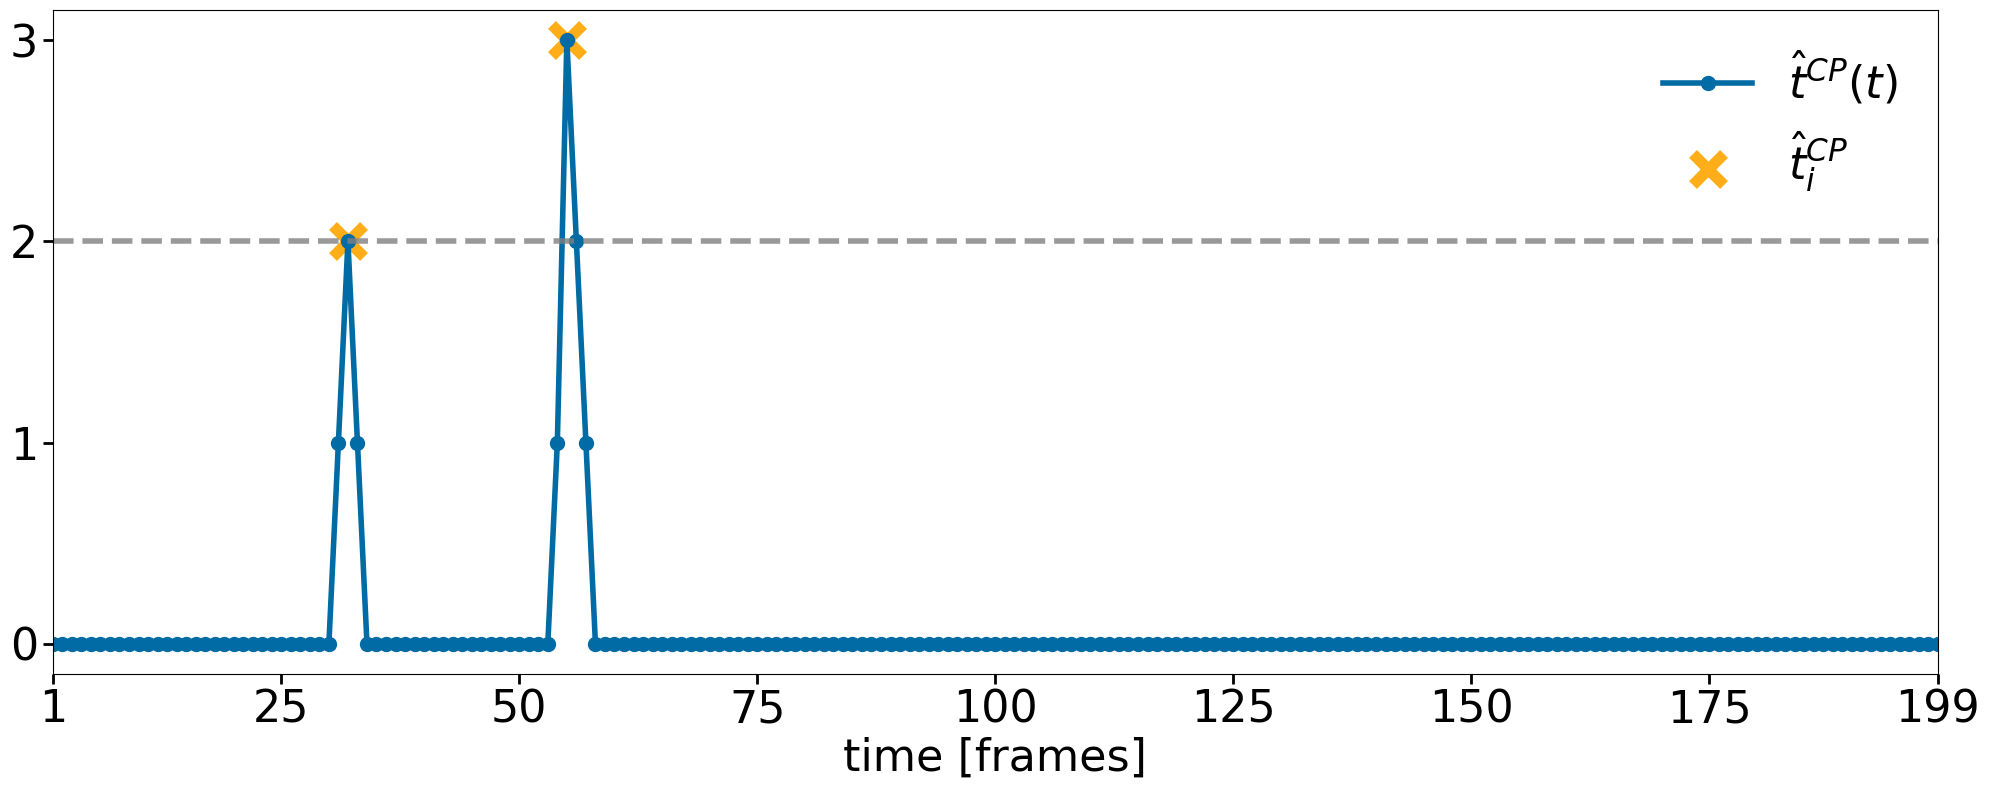

In [15]:
t=trackt # index of trajectory in rawTrajs array
fs=32
plt.figure(figsize=(20,8))
times= np.arange(1,len(alphaMeansPred[t])+1,1)

plt.plot(times,cpsTrajSignal,'-o',markersize=10,lw=4,label='$\hat t^{CP}(t)$')
plt.scatter(CPWinPred[t],cpsTrajSignal[CPWinPred[t]-1],s=500,marker='x',lw=8,color='orange',label='$\hat t^{CP}_i$',alpha=0.9)

plt.axhline(2,ls='dashed',lw=4,color='grey',alpha=0.8)
plt.xlim(times[0],times[-1])
plt.yticks([0,1,2,3],fontsize=fs)
plt.xticks([1,25,50,75,100,125,150,175,199],fontsize=fs)
plt.xlabel('time [frames]',fontsize=fs)
plt.legend(fontsize=fs, frameon=0)
plt.tick_params(width=2,length=7)
plt.tight_layout()

plt.show()

### Point-wise Predictions

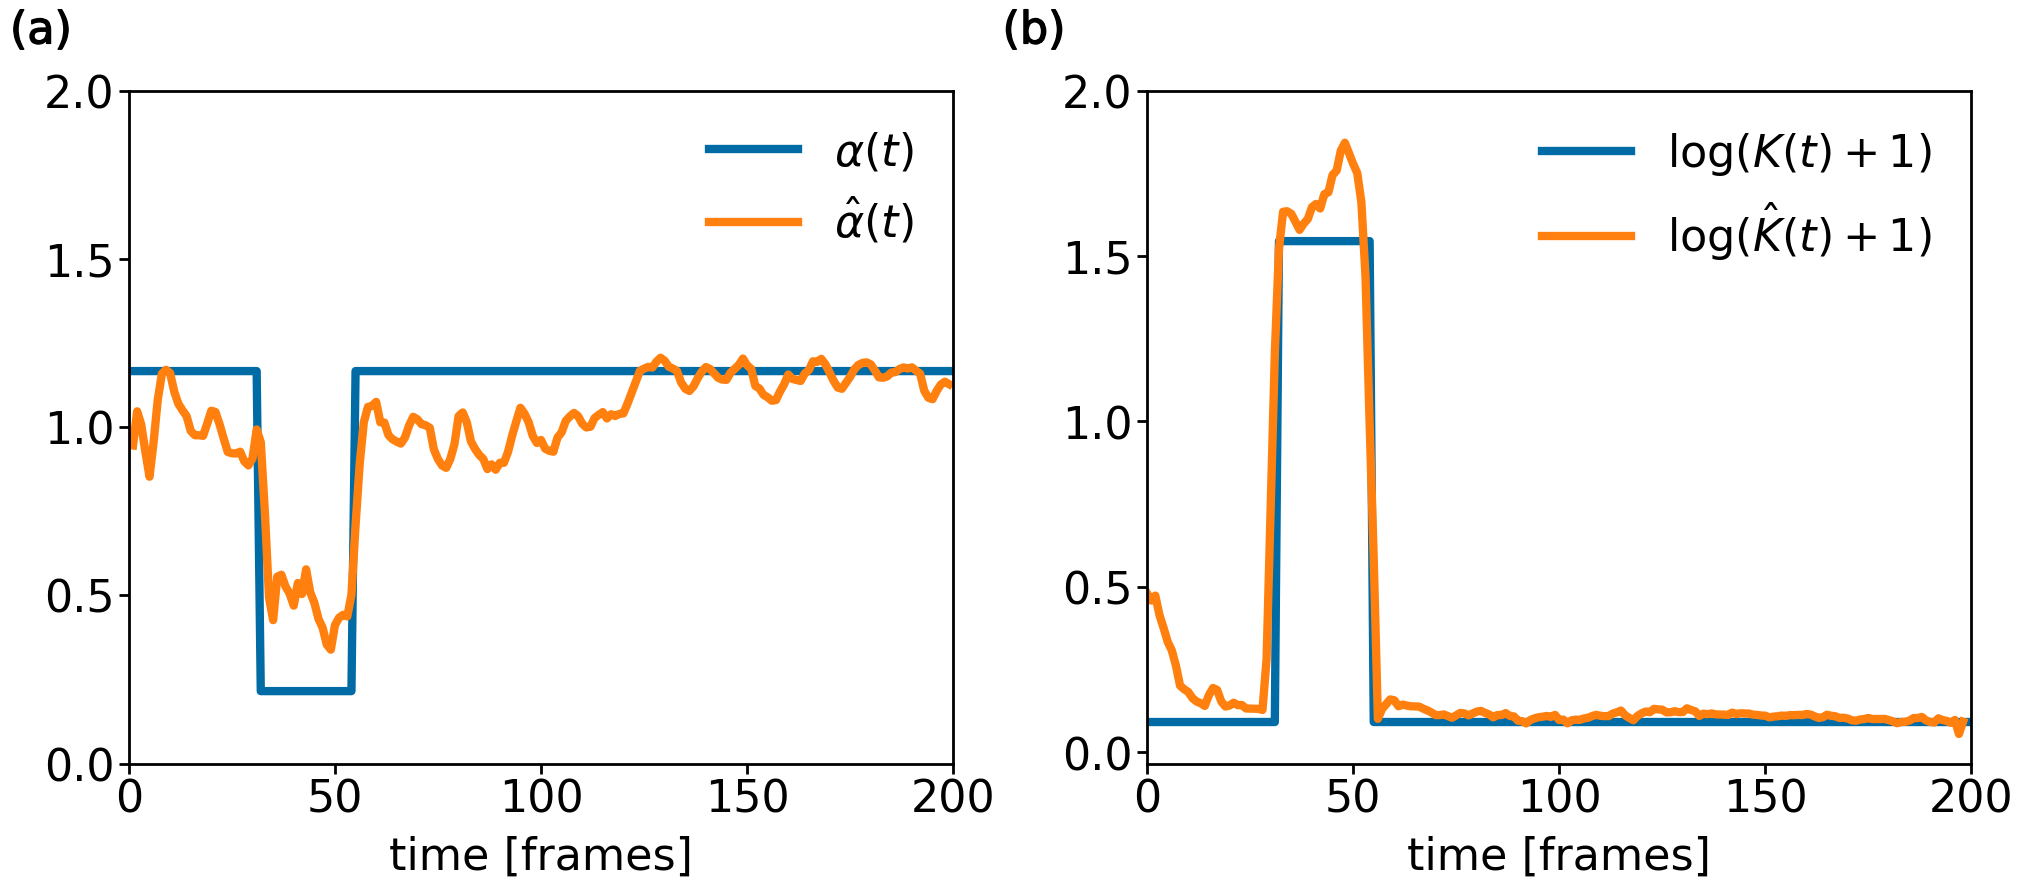

0


In [16]:
t=0 # trajectory index
fs=32
plt.rcParams['axes.linewidth'] = 2.0
length = len(rawTrajs[t][0])
times= np.arange(1,len(alphaMeansPred[t])+1,1)
plt.figure(figsize=(20,9))

plt.subplot(1,2,1)
plt.plot(gtLabels[t][0], label = r"$α(t)$",lw=6)
plt.plot(times,alphaMeansPred[t], label = r"$\hat{α}(t)$",lw=6)
ytic = [0,0.5,1,1.5,2]
xtic = [0, 50, 100,150,200]
plt.xlabel("time [frames]",fontsize=fs,labelpad=10)
plt.xticks(xtic,fontsize=fs)
plt.yticks(ytic,fontsize=fs)
plt.tick_params(length=7,width=2)
plt.legend(fontsize=fs,frameon=0)
plt.xlim(0,length)
plt.ylim(0,2)
ax1 = plt.subplot(1,2,1)
tx1=ax1.text(-28.85, ax1.get_ylim()[1] * 1.07, '(a)', fontsize=fs)
tx1.set_path_effects([path_effects.Stroke(linewidth=1., foreground='black'), 
                        path_effects.Normal()])
plt.subplot(1,2,2)
plt.plot(np.log(np.array(gtLabels[t][1])+1), label = r"$\log (K(t)+1)$",lw=6)
plt.plot(np.log(np.array(KMeansPred[t])+1), label = r"$\log (\hat{K}(t)+1)$",lw=6)
eps = 0.05
plt.xlim(0,length)
plt.xlabel("time [frames]",fontsize=fs,labelpad=10)
plt.xticks(xtic,fontsize=fs)
ytic = [0,0.5,1,1.5,2.]
plt.yticks(ytic,fontsize=fs)
plt.tick_params(length=7,width=2)
plt.legend(fontsize=fs,frameon=0)
ax2 = plt.subplot(1,2,2)
tx2=ax1.text(ax2.get_xlim()[1]*1.06, ax2.get_ylim()[1] * 1.07, '(b)', fontsize=fs)
tx2.set_path_effects([path_effects.Stroke(linewidth=1., foreground='black'), 
                        path_effects.Normal()])
plt.subplots_adjust(wspace=1)
plt.tight_layout()
plt.show()
print(t)

### Changepoint predictions

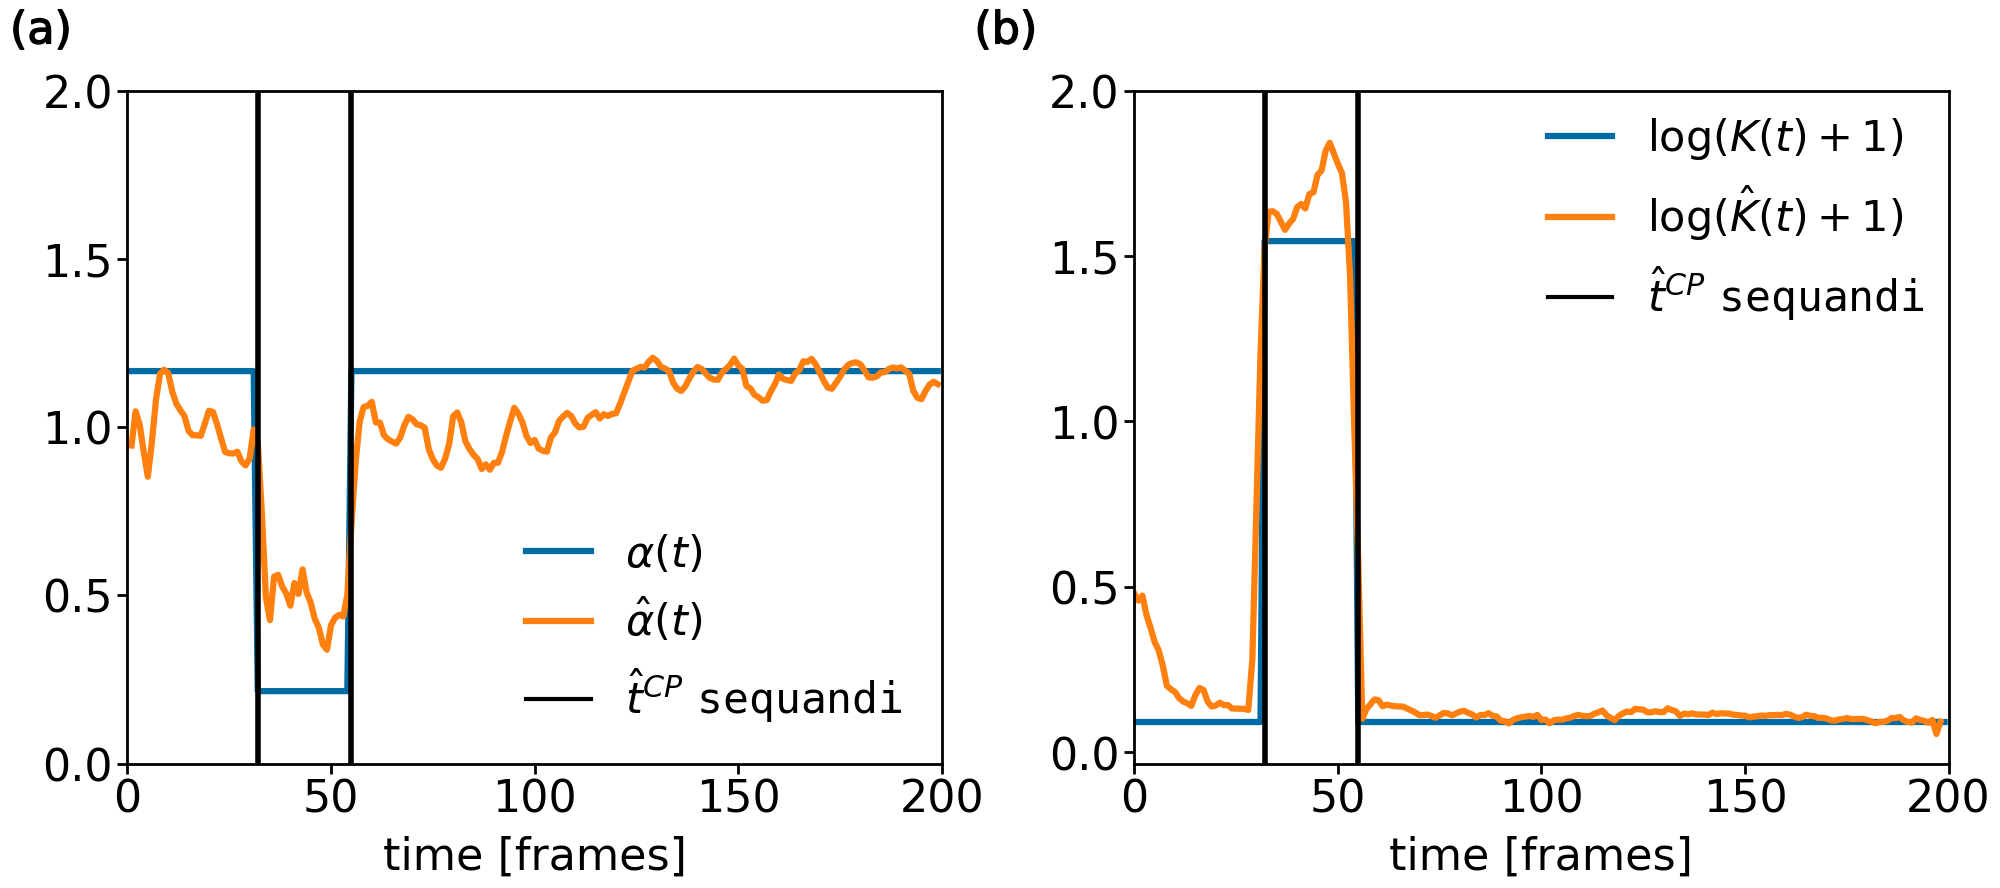

In [24]:
t = 0
times= np.arange(1,len(alphaMeansPred[t])+1,1)

plt.figure(figsize=(20,9))
plt.subplot(1,2,1)


length = len(rawTrajs[t][0])
plt.plot(gtLabels[t][0], label = r"$α(t)$",lw=4.5)
plt.plot(times,alphaMeansPred[t], label = "$\hat{α}(t)$",lw=4.5)
plt.plot([],color='black',label=r'$\hat{t}^{CP}$ $\mathtt{sequandi}$',lw=3)
cp2 = 1
for cp in list(CPWinPred[t])+[length]:
    if cp!=length:
        plt.axvline(cp,color='black',lw=4)
    cp_mean = np.mean(alphaMeansPred[t][cp2-1:cp-1])
    cp2 = np.copy(cp)
plt.xlabel("time [frames]",fontsize=fs,labelpad=10)
ytic = [0,0.5,1,1.5,2]
xtic = [0, 50, 100,150,200]
plt.xticks(xtic,fontsize=fs)
plt.yticks(ytic,fontsize=fs)
plt.tick_params(length=7,width=2)
legend = plt.legend(loc='lower right', fontsize=fs-1,handlelength=1.5)
legend.get_frame().set_linewidth(0)  # Removes the border
legend.get_frame().set_facecolor('white')  # Ensures background is white
legend.get_frame().set_alpha(0.8)  # Semi-transparent background
plt.xlim(0,length)
plt.ylim(0,2)
ax1 = plt.subplot(1,2,1)
tx1=ax1.text(-28.85, ax1.get_ylim()[1] * 1.07, '(a)', fontsize=fs)
tx1.set_path_effects([path_effects.Stroke(linewidth=1., foreground='black'), 
                        path_effects.Normal()])


plt.subplot(1,2,2)

plt.plot(np.log(np.array(gtLabels[t][1])+1), label = r"$\log (K(t)+1)$",lw=4.5)
plt.plot(np.log(np.array(KMeansPred[t])+1), label = r"$\log (\hat{K}(t)+1)$",lw=4.5)
plt.plot([],color='black',label=r'$\hat{t}^{CP}$ $\mathtt{sequandi}$',lw=3)
cp2 = 1
for cp in list(CPWinPred[t])+[length]:
    if cp!=length:
        plt.axvline(cp,color='black',lw=4)
    cp_mean = np.mean(np.log(np.array(KMeansPred[t][cp2-1:cp-1])+1))
    cp2 = np.copy(cp)

plt.xlim(0,length)
plt.xlabel("time [frames]",fontsize=fs, labelpad=10)
plt.xticks(xtic,fontsize=fs)
plt.yticks(ytic,fontsize=fs)
plt.tick_params(length=7,width=2)

legend = plt.legend(loc='upper left', bbox_to_anchor=(0.46, 1.02), fontsize=fs-1,handlelength=1.5)
legend.get_frame().set_linewidth(0)  # Removes the border
legend.get_frame().set_facecolor('white')  # Ensures background is white
legend.get_frame().set_alpha(0.8)  # Semi-transparent background

ax2 = plt.subplot(1,2,2)
tx2=ax1.text(ax2.get_xlim()[1]*1.04, ax2.get_ylim()[1] * 1.07, '(b)', fontsize=fs)
tx2.set_path_effects([path_effects.Stroke(linewidth=1., foreground='black'), 
                        path_effects.Normal()])

plt.subplots_adjust(wspace=.10)
plt.tight_layout()
plt.show()

### Segmented predictions

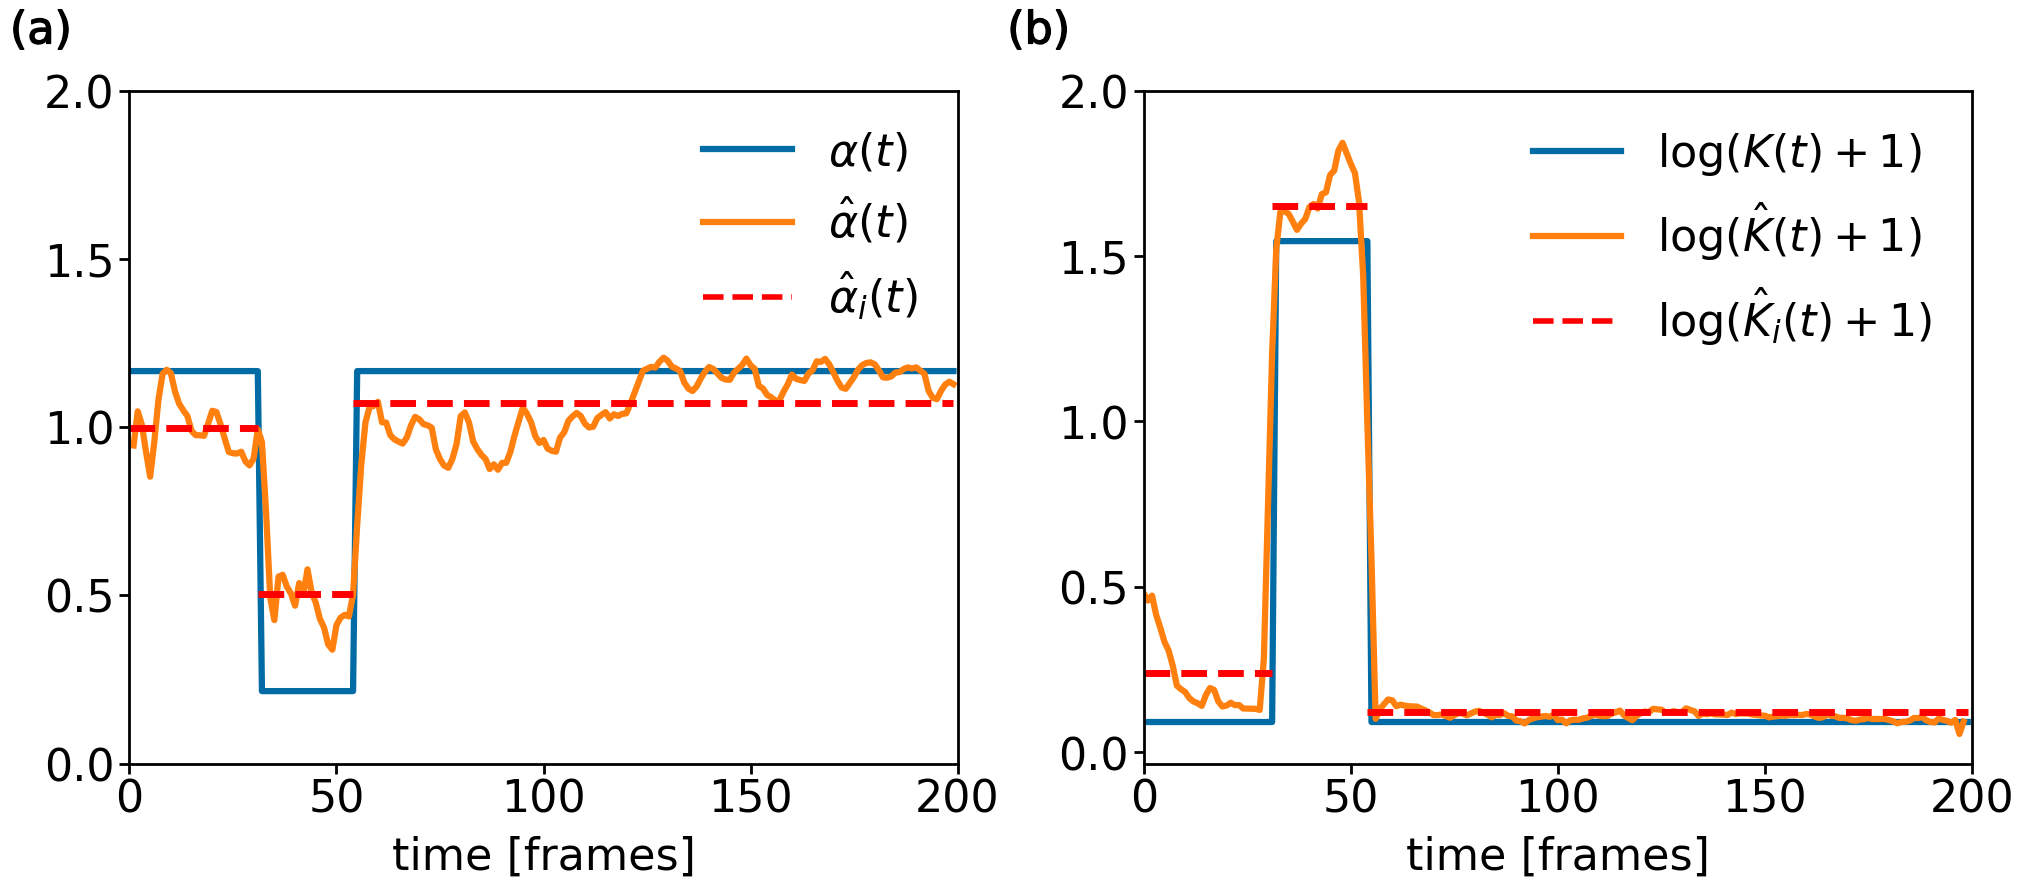

In [25]:
t = 0
times= np.arange(1,len(alphaMeansPred[t])+1,1)

plt.figure(figsize=(20,9))
plt.subplot(1,2,1)


length = len(rawTrajs[t][0])

plt.plot(gtLabels[t][0], label = r"$α(t)$",lw=4.5)
plt.plot(times,alphaMeansPred[t], label = "$\hat{α}(t)$",lw=4.5)
plt.plot([],ls='dashed',color='red',label=r'$ \hat{α}_{i}(t)$',lw=4)

# use the changepoints to partition and average the point-wise alpha predictions
cp2 = 1
for cp in list(CPWinPred[t])+[length]:
    cp_mean = np.mean(alphaMeansPred[t][cp2-1:cp-1])
    plt.plot([cp2-1,cp-1],[cp_mean,cp_mean],ls='dashed',color='red',lw=5)
    cp2 = np.copy(cp)

plt.xlabel("time [frames]",fontsize=fs,labelpad=10)
ytic = [0,0.5,1,1.5,2]
xtic = [0, 50, 100,150,200]
plt.xticks(xtic,fontsize=fs)
plt.yticks(ytic,fontsize=fs)
plt.tick_params(length=7,width=2)
plt.legend(fontsize=fs,frameon=0)
plt.xlim(0,length)
plt.ylim(0,2)
ax1 = plt.subplot(1,2,1)
tx1=ax1.text(-28.85, ax1.get_ylim()[1] * 1.07, '(a)', fontsize=fs)
tx1.set_path_effects([path_effects.Stroke(linewidth=1., foreground='black'), 
                        path_effects.Normal()])


plt.subplot(1,2,2)

plt.plot(np.log(np.array(gtLabels[t][1])+1), label = r"$\log (K(t)+1)$",lw=4.5)
plt.plot(np.log(np.array(KMeansPred[t])+1), label = r"$\log (\hat{K}(t)+1)$",lw=4.5)
plt.plot([],ls='dashed',color='red',label=r'$\log ( \hat{K}_{i}(t) +1)$',lw=4)

# use the changepoints to partition and average the point-wise alpha predictions
cp2=1
for cp in list(CPWinPred[t])+[length]:
    cp_mean = np.mean(np.log(np.array(KMeansPred[t][cp2-1:cp-1])+1))
    plt.plot([cp2-1,cp-1],[cp_mean,cp_mean],ls='dashed',color='red',lw=5)
    cp2 = np.copy(cp)

plt.xlim(0,length)
plt.xlabel("time [frames]",fontsize=fs,labelpad=10)
plt.xticks(xtic,fontsize=fs)
plt.yticks(ytic,fontsize=fs)
plt.tick_params(length=7,width=2)
plt.legend(fontsize=fs,frameon=0)

ax2 = plt.subplot(1,2,2)
tx2=ax1.text(ax2.get_xlim()[1]*1.06, ax2.get_ylim()[1] * 1.07, '(b)', fontsize=fs)
tx2.set_path_effects([path_effects.Stroke(linewidth=1., foreground='black'), 
                        path_effects.Normal()])

plt.subplots_adjust(wspace=2.)
plt.tight_layout()
plt.show()